# Why Python is Slow: Looking Under the Hood

*This notebook originally appeared as a blog post by Jake VanderPlas on [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD-licensed.*

We've all heard it before: Python is slow.

When I teach courses on Python for scientific computing, I make this point [very early](http://nbviewer.ipython.org/github/jakevdp/2013_fall_ASTR599/blob/master/notebooks/11_EfficientNumpy.ipynb) in the course, and tell the students why: it boils down to Python being a dynamically typed, interpreted language, where values are stored not in dense buffers but in scattered objects.  And then I talk about how to get around this by using NumPy, SciPy, and related tools for vectorization of operations and calling into compiled code, and go on from there.

But I realized something recently: despite the relative accuracy of the above statements, the words "dynamically-typed-interpreted-buffers-vectorization-compiled" probably mean very little to somebody attending an intro programming seminar. The jargon does little to enlighten people about what's actually going on "under the hood", so to speak.

So I decided I would write this post, and dive into the details that I usually gloss over. Along the way, we'll take a look at using Python's standard library to introspect the goings-on of CPython itself. So whether you're a novice or experienced programmer, I hope you'll learn something from the following exploration.

## Why Python is Slow

Python is slower than Fortran and C for a variety of reasons:

### 1. **Python is Dynamically Typed rather than Statically Typed**.

What this means is that at the time the program executes, the interpreter doesn't know the type of the variables that are defined.  The difference between a C variable (I'm using C as a stand-in for compiled languages) and a Python variable is summarized by this diagram:

![cint vs pyint](http://jakevdp.github.io/images/cint_vs_pyint.png)

For a variable in C, the compiler knows the type by its very definition. For a variable in Python, all you know at the time the program executes is that it's some sort of Python object.

So if you write the following in C:

``` C
/* C code */
int a = 1;
int b = 2;
int c = a + b;
```

the C compiler knows from the start that ``a`` and ``b`` are integers: they simply can't be anything else! With this knowledge, it can call the routine which adds two integers, returning another integer which is just a simple value in memory. As a rough schematic, the sequence of events looks like this:

#### C Addition

1. Assign ``<int> 1`` to ``a``
2. Assign ``<int> 2`` to ``b``
3. call ``binary_add<int, int>(a, b)``
4. Assign the result to c

The equivalent code in Python looks like this:

``` python
# python code
a = 1
b = 2
c = a + b
```

here the interpreter knows only that ``1`` and ``2`` are objects, but not what type of object they are. So the interpreter must inspect ``PyObject_HEAD`` for each variable to find the type information, and then call the appropriate summation routine for the two types. Finally it must create and initialize a new Python object to hold the return value.  The sequence of events looks roughly like this:

#### Python Addition

1. Assign ``1`` to ``a``

   - **1a.** Set ``a->PyObject_HEAD->typecode`` to integer
   - **1b.** Set ``a->val = 1``

2. Assign ``2`` to ``b``

   - **2a.** Set ``b->PyObject_HEAD->typecode`` to integer
   - **2b.** Set ``b->val = 2``
   
3. call ``binary_add(a, b)``

   - **3a.** find typecode in ``a->PyObject_HEAD``
   - **3b.** ``a`` is an integer; value is ``a->val``
   - **3c.** find typecode in ``b->PyObject_HEAD``
   - **3d.** ``b`` is an integer; value is ``b->val``
   - **3e.** call ``binary_add<int, int>(a->val, b->val)``
   - **3f.** result of this is ``result``, and is an integer.
   
4. Create a Python object ``c``
   
   - **4a.** set ``c->PyObject_HEAD->typecode`` to integer
   - **4b.** set ``c->val`` to ``result``
   
The dynamic typing means that there are a lot more steps involved with any operation. This is a primary reason that Python is slow compared to C for operations on numerical data.

### 2. Python is interpreted rather than compiled.

We saw above one difference between interpreted and compiled code. A smart compiler can look ahead and optimize for repeated or unneeded operations, which can result in speed-ups. Compiler optimization is its own beast, and I'm personally not qualified to say much about it, so I'll stop there.  For some examples of this in action, you can take a look at my [previous post](http://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2/) on Numba and Cython.

### 3. Python's object model can lead to inefficient memory access

We saw above the extra type info layer when moving from a C integer to a Python integer. Now imagine you have many such integers and want to do some sort of batch operation on them.  In Python you might use the standard ``List`` object, while in C you would likely use some sort of buffer-based array.

A NumPy array in its simplest form is a Python object build around a C array. That is, it has a pointer to a *contiguous* data buffer of values. A Python list, on the other hand, has a pointer to a contiguous buffer of pointers, each of which points to a Python object which in turn has references to its data (in this case, integers).  This is a schematic of what the two might look like:

![array vs list](http://jakevdp.github.io/images/array_vs_list.png)

It's easy to see that if you're doing some operation which steps through data in sequence, the numpy layout will be much more efficient than the Python layout, both in the cost of storage and the cost of access.

### So Why Use Python?

Given this inherent inefficiency, why would we even think about using Python? Well, it comes down to this: Dynamic typing makes Python **easier to use** than C.  It's extremely **flexible and forgiving**, this flexibility leads to **efficient use of development time**, and on those occasions that you really need the optimization of C or Fortran, **Python offers easy hooks into compiled libraries**. It's why Python use within many scientific communities has been continually growing. With all that put together, Python ends up being an extremely efficient language for the overall task of doing science with code.

## Python meta-hacking: Don't take my word for it

Above I've talked about some of the internal structures that make Python tick, but I don't want to stop there. As I was putting together the above summary, I started hacking around on the internals of the Python language, and found that the process itself is pretty enlightening.

In the following sections, I'm going to *prove* to you that the above information is correct, by doing some hacking to expose Python objects using Python itself.  Please note that everything below is written using **Python 3.4**. Earlier versions of Python have a slightly different internal object structure, and later versions may tweak this further. Please make sure to use the correct version!  Also, most of the code below assumes a 64-bit CPU. If you're on a 32-bit platform, some of the C types below will have to be adjusted to account for this difference.

In [1]:
import sys
print("Python version =", sys.version[:5])

Python version = 3.4.0


### Digging into Python Integers

Integers in Python are easy to create and use:

In [2]:
x = 42
print(x)

42


But the simplicity of this interface belies the complexity of what is happening under the hood. We briefly discussed the memory layout of Python integers above.  Here we'll use Python's built-in ``ctypes`` module to introspect Python's integer type from the Python interpreter itself.  But first we need to know exactly what a Python integer looks like at the level of the C API.

The actual ``x`` variable in CPython is stored in a structure which is defined in the CPython source code, in [Include/longintrepr.h](http://hg.python.org/cpython/file/3.4/Include/longintrepr.h/#l89)

``` C
struct _longobject {
	PyObject_VAR_HEAD
	digit ob_digit[1];
};
```

The ``PyObject_VAR_HEAD`` is a macro which starts the object off with the following struct, defined in [Include/object.h](http://hg.python.org/cpython/file/3.4/Include/object.h#l111):

``` C
typedef struct {
    PyObject ob_base;
    Py_ssize_t ob_size; /* Number of items in variable part */
} PyVarObject;
```

... and includes a ``PyObject`` element, which is also defined in [Include/object.h](http://hg.python.org/cpython/file/3.4/Include/object.h#l105):

``` C
typedef struct _object {
    _PyObject_HEAD_EXTRA
    Py_ssize_t ob_refcnt;
    struct _typeobject *ob_type;
} PyObject;
```

here ``_PyObject_HEAD_EXTRA`` is a macro which is not normally used in the Python build.

With all this put together and typedefs/macros unobfuscated, our integer object works out to something like the following structure:

``` C
struct _longobject {
    long ob_refcnt;
    PyTypeObject *ob_type;
    size_t ob_size;
	long ob_digit[1];
};
```

The ``ob_refcnt`` variable is the reference count for the object, the ``ob_type`` variable is a pointer to the structure containing all the type information and method definitions for the object, and the ``ob_digit`` holds the actual numerical value.

Armed with this knowledge, we'll use the ``ctypes`` module to start looking into the actual object structure and extract some of the above information.

We start with defining a Python representation of the C structure:

In [3]:
import ctypes

class IntStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_size", ctypes.c_ulong),
                ("ob_digit", ctypes.c_long)]
    
    def __repr__(self):
        return ("IntStruct(ob_digit={self.ob_digit}, "
                "refcount={self.ob_refcnt})").format(self=self)

Now let's look at the internal representation for some number, say 42.  We'll use the fact that in CPython, the ``id`` function gives the memory location of the object:

In [4]:
num = 42
IntStruct.from_address(id(42))

IntStruct(ob_digit=42, refcount=35)

The ``ob_digit`` attribute points to the correct location in memory!

But what about ``refcount``? We've only created a single value: why is the reference count so much greater than one?

Well it turns out that Python uses small integers *a lot*. If a new ``PyObject`` were created for each of these integers, it would take a lot of memory. Because of this, Python implements common integer values as **singletons**: that is, only one copy of these numbers exist in memory. In other words, every time you create a new Python integer in this range, you're simply creating a reference to the singleton with that value:

In [5]:
x = 42
y = 42
id(x) == id(y)

True

Both variables are simply pointers to the same memory address.  When you get to much bigger integers (larger than 255 in Python 3.4), this is no longer true:

In [6]:
x = 1234
y = 1234
id(x) == id(y)

False

Just starting up the Python interpreter will create a lot of integer objects; it can be interesting to take a look at how many references there are to each:

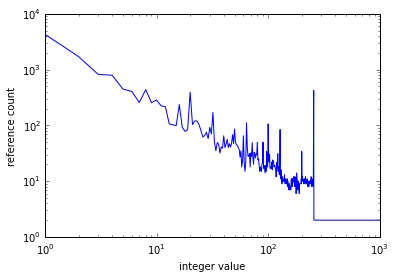

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
plt.loglog(range(1000), [sys.getrefcount(i) for i in range(1000)])
plt.xlabel('integer value')
plt.ylabel('reference count')

We see that zero is referenced several thousand times, and as you may expect, the frequency of references generally decreases as the value of the integer increases.

Just to further make sure that this is behaving as we'd expect, let's make sure the ``ob_digit`` field holds the correct value:

In [8]:
all(i == IntStruct.from_address(id(i)).ob_digit
    for i in range(256))

True

If you go a bit deeper into this, you might notice that this does not hold for numbers larger than 256: it turns out that some bit-shift gymnastics are performed in [Objects/longobject.c](http://hg.python.org/cpython/file/3.4/Objects/longobject.c#l232), and these change the way large integers are represented in memory.

I can't say that I fully understand why exactly that is happening, but I imagine it has something to do with Python's ability to efficiently handle integers past the overflow limit of the long int data type, as we can see here:

In [9]:
2 ** 100

1267650600228229401496703205376

That number is much too long to be a ``long``, which can only hold 64 bits worth of values (that is, up to $\sim2^{64}$)

### Digging into Python Lists

Let's apply the above ideas to a more complicated type: Python lists. Analogously to integers, we find the definition of the list object itself in [Include/listobject.h](http://hg.python.org/cpython/file/3.4/Include/listobject.h#l23):

``` C
typedef struct {
    PyObject_VAR_HEAD
    PyObject **ob_item;
    Py_ssize_t allocated;
} PyListObject;
```

Again, we can expand the macros and de-obfuscate the types to see that the structure is effectively the following:

``` C
typedef struct {
    long ob_refcnt;
    PyTypeObject *ob_type;
    Py_ssize_t ob_size;
    PyObject **ob_item;
    long allocated;
} PyListObject;
```

Here the ``PyObject **ob_item`` is what points to the contents of the list, and the ``ob_size`` value tells us how many items are in the list.

In [10]:
class ListStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_size", ctypes.c_ulong),
                ("ob_item", ctypes.c_long),  # PyObject** pointer cast to long
                ("allocated", ctypes.c_ulong)]
    
    def __repr__(self):
        return ("ListStruct(len={self.ob_size}, "
                "refcount={self.ob_refcnt})").format(self=self)

Let's try it out:

In [11]:
L = [1,2,3,4,5]
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=1)

Just to make sure we've done things correctly, let's create a few extra references to the list, and see how it affects the reference count:

In [12]:
tup = [L, L]  # two more references to L
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=3)

Now let's see about finding the actual elements within the list.

As we saw above, the elements are stored via a contiguous array of ``PyObject`` pointers.  Using ``ctypes``, we can actually create a compound structure consisting of our ``IntStruct`` objects from before:

In [13]:
# get a raw pointer to our list
Lstruct = ListStruct.from_address(id(L))

# create a type which is an array of integer pointers the same length as L
PtrArray = Lstruct.ob_size * ctypes.POINTER(IntStruct)

# instantiate this type using the ob_item pointer
L_values = PtrArray.from_address(Lstruct.ob_item)

Now let's take a look at the values in each of the items:

In [14]:
[ptr[0] for ptr in L_values]  # ptr[0] dereferences the pointer

[IntStruct(ob_digit=1, refcount=5296),
 IntStruct(ob_digit=2, refcount=2887),
 IntStruct(ob_digit=3, refcount=932),
 IntStruct(ob_digit=4, refcount=1049),
 IntStruct(ob_digit=5, refcount=808)]

We've recovered the ``PyObject`` integers within our list! You might wish to take a moment to look back up to the schematic of the List memory layout above, and make sure you understand how these ``ctypes`` operations map onto that diagram.

### Digging into NumPy arrays

Now, for comparison, let's do the same introspection on a numpy array.  I'll skip the detailed walk-through of the NumPy C-API array definition; if you want to take a look at it, you can find it in [numpy/core/include/numpy/ndarraytypes.h](https://github.com/numpy/numpy/blob/maintenance/1.8.x/numpy/core/include/numpy/ndarraytypes.h#L646)

Note that I'm using NumPy version 1.8 here; these internals may have changed between versions, though I'm not sure whether this is the case.

In [15]:
import numpy as np
np.__version__

'1.8.1'

Let's start by creating a structure that represents the numpy array itself. This should be starting to look familiar...

We'll also add some custom properties to access Python versions of the shape and strides:

In [16]:
class NumpyStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_data", ctypes.c_long),  # char* pointer cast to long
                ("ob_ndim", ctypes.c_int),
                ("ob_shape", ctypes.c_voidp),
                ("ob_strides", ctypes.c_voidp)]
    
    @property
    def shape(self):
        return tuple((self.ob_ndim * ctypes.c_int64).from_address(self.ob_shape))
    
    @property
    def strides(self):
        return tuple((self.ob_ndim * ctypes.c_int64).from_address(self.ob_strides))
    
    def __repr__(self):
        return ("NumpyStruct(shape={self.shape}, "
                "refcount={self.ob_refcnt})").format(self=self)

Now let's try it out:

In [17]:
x = np.random.random((10, 20))
xstruct = NumpyStruct.from_address(id(x))
xstruct

NumpyStruct(shape=(10, 20), refcount=1)

We see that we've pulled out the correct shape information.  Let's make sure the reference count is correct:

In [18]:
L = [x,x,x]  # add three more references to x
xstruct

NumpyStruct(shape=(10, 20), refcount=4)

Now we can do the tricky part of pulling out the data buffer. For simplicity we'll ignore the strides and assume it's a C-contiguous array; this could be generalized with a bit of work.

In [19]:
x = np.arange(10)
xstruct = NumpyStruct.from_address(id(x))
size = np.prod(xstruct.shape)

# assume an array of integers
arraytype = size * ctypes.c_long
data = arraytype.from_address(xstruct.ob_data)

[d for d in data]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

The ``data`` variable is now a view of the contiguous block of memory defined in the NumPy array!  To show this, we'll change a value in the array...

In [20]:
x[4] = 555
[d for d in data]

[0, 1, 2, 3, 555, 5, 6, 7, 8, 9]

... and observe that the data view changes as well.  Both ``x`` and ``data`` are pointing to the same contiguous block of memory.

Comparing the internals of the Python list and the NumPy ndarray, it is clear that NumPy's arrays are **much, much** simpler for representing a list of identically-typed data. That fact is related to what makes it more efficient for the compiler to handle as well.

## Just for fun: a few "never use these" hacks

Using ``ctypes`` to wrap the C-level data behind Python objects allows you to do some pretty interesting things. With proper attribution to my friend James Powell, I'll say it here: [seriously, don't use this code](http://seriously.dontusethiscode.com/). While nothing below should actually be used (ever), I still find it all pretty interesting!

### Modifying the Value of an Integer

Inspired by [this Reddit post](http://www.reddit.com/r/Python/comments/2441cv/can_you_change_the_value_of_1/), we can actually modify the numerical value of integer objects! If we use a common number like ``0`` or ``1``, we're very likely to crash our Python kernel. But if we do it with less important numbers, we can get away with it, at least briefly.

Note that this is a *really, really* bad idea. In particular, if you're running this in an IPython notebook, you might corrupt the IPython kernel's very ability to run (because you're screwing with the variables in its runtime). Nevertheless, we'll cross our fingers and give it a shot:

In [21]:
# WARNNG: never do this!
id113 = id(113)
iptr = IntStruct.from_address(id113)
iptr.ob_digit = 4  # now Python's 113 contains a 4!

113 == 4

True

But note now that we can't set the value back in a simple manner, because the true value ``113`` no longer exists in Python!

In [22]:
113

4

In [23]:
112 + 1

4

One way to recover is to manipulate the bytes directly. We know that $113 = 7 \times 16^1 + 1 * 16^0$, so **on a little-endian 64-bit system running Python 3.4**, the following should work:

In [24]:
ctypes.cast(id113, ctypes.POINTER(ctypes.c_char))[3 * 8] = b'\x71'
112 + 1

113

and we're back!

Just in case I didn't stress it enough before: **never do this.**

### In-place Modification of List Contents

Above we did an in-place modification of a value in a numpy array. This is easy, because a numpy array is simply a data buffer. But might we be able to do the same thing for a list? This gets a bit more tricky, because lists store *references* to values rather than the values themselves. And to not crash Python itself, you need to be very careful to keep track of these reference counts as you muck around.  Here's how it can be done:

In [25]:
# WARNING: never do this!
L = [42]
Lwrapper = ListStruct.from_address(id(L))
item_address = ctypes.c_long.from_address(Lwrapper.ob_item)
print("before:", L)

# change the c-pointer of the list item
item_address.value = id(6)

# we need to update reference counts by hand
IntStruct.from_address(id(42)).ob_refcnt -= 1
IntStruct.from_address(id(6)).ob_refcnt += 1

print("after: ", L)

before: [42]
after:  [6]


Like I said, you should never use this, and I honestly can't think of any reason why you would want to. But it gives you an idea of the types of operations the interpreter has to do when modifying the contents of a list. Compare this to the NumPy example above, and you'll see one reason why Python lists have more overhead than Python arrays.

### Meta Goes Meta: a self-wrapping Python object

Using the above methods, we can start to get even stranger. The ``Structure`` class in ``ctypes`` is itself a Python object, which can be seen in [Modules/_ctypes/ctypes.h](http://hg.python.org/cpython/file/3.4/Modules/_ctypes/ctypes.h#l46). Just as we wrapped ints and lists, we can wrap structures themselves as follows:

In [26]:
class CStructStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_ptr", ctypes.c_long),  # char* pointer cast to long
                    ]
    
    def __repr__(self):
        return ("CStructStruct(ptr=0x{self.ob_ptr:x}, "
                "refcnt={self.ob_refcnt})").format(self=self)

Now we'll attempt to make a structure that wraps itself. We can't do this directly, because we don't know at what address in memory the new structure will be created. But what we can do is create a *second* structure wrapping the first, and use this to modify its contents in-place!

We'll start by making a temporary meta-structure and wrapping it:

In [27]:
tmp = IntStruct.from_address(id(0))
meta = CStructStruct.from_address(id(tmp))

print(repr(meta))

CStructStruct(ptr=0x10023ef00, refcnt=1)


Now we add a third structure, and use it to adjust the memory value of the second in-place:

In [28]:
meta_wrapper = CStructStruct.from_address(id(meta))
meta_wrapper.ob_ptr = id(meta)

print(meta.ob_ptr == id(meta))
print(repr(meta))

True
CStructStruct(ptr=0x106d828c8, refcnt=7)


We now have a self-wrapping Python structure!

Again, I can't think of any reason you'd ever want to do this. And keep in mind there is noting groundbreaking about this type of self-reference in Python – due to its dynamic typing, it is realatively straightforward to do things like this without directly hacking the memory:

In [29]:
L = []
L.append(L)
print(L)

[[...]]


## Conclusion

Python is slow. And one big reason for that, as we've seen, is the type indirection under the hood which makes Python quick, easy, and fun for the developer.  And as we've seen, Python itself offers tools that can be used to hack into the Python objects themselves.

I hope that this was made more clear through this exploration of the differences between various objects, and some liberal mucking around in the internals of CPython itself. This exercise was extremely enlightening for me, and I hope it was for you as well...  Happy hacking!

*This blog post was written entirely in the IPython Notebook.  The full notebook can be downloaded
[here](http://jakevdp.github.io/downloads/notebooks/WhyPythonIsSlow.ipynb),
or viewed statically
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/WhyPythonIsSlow.ipynb).*